In [92]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import dipy.reconst.sfm as sfm
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti
import dipy.core.gradients as grad
import dipy.reconst.cross_validation as xval
import dipy.data as dpd
import utils
import model as mm 
from model import Model, BiExponentialIsotropicModel, my_responses
from parallelization import parallelization
import csv

In [93]:
version = '5'

In [94]:
sphere = dpd.get_sphere()
#sphere = sphere.subdivide(1)

In [95]:
# Load Data
data_dict = utils.read_data()
data = data_dict['seen']['signal'][:, range(1)]
bvals = data_dict['seen']['bvals']
bvecs = data_dict['seen']['bvecs']
delta = data_dict['seen']['delta']
Delta = data_dict['seen']['Delta']
te = data_dict['seen']['TE']
g = data_dict['seen']['g']

In [96]:
data_seen = []
data_unseen = []
te_seen = []
te_unseen = []
gtab_seen = []
gtab_unseen = []
g_seen = []
g_unseen = []

mask = utils.create_shells()
for m in range(data.shape[-1]): # for every voxel
    for j in range(0, len(mask)): # for every TE
        for i in range(0, len(mask[j])): # for every shell
            mask_unseen = mask[j][i]
            mask_seen = np.invert(mask_unseen)
            data_seen.append(data[mask_seen, m])
            data_unseen.append(data[mask_unseen, m])
            te_seen.append(te[mask_seen])
            te_unseen.append(te[mask_unseen])
            g_unseen.append(g[mask_unseen])
            g_seen.append(g[mask_seen])
            bvals_seen_temp = bvals[mask_seen]
            bvecs_seen_temp = bvecs[mask_seen]
            delta_seen_temp = delta[mask_seen]
            Delta_seen_temp = Delta[mask_seen]
            gtab_seen.append(grad.gradient_table(bvals_seen_temp, bvecs_seen_temp, big_delta=Delta_seen_temp, small_delta=delta_seen_temp))
            bvals_unseen_temp = bvals[mask_unseen]
            bvecs_unseen_temp = bvecs[mask_unseen]
            delta_unseen_temp = delta[mask_unseen]
            Delta_unseen_temp = Delta[mask_unseen]
            gtab_unseen.append(grad.gradient_table(bvals_unseen_temp, bvecs_unseen_temp, big_delta=Delta_unseen_temp, small_delta=delta_unseen_temp))

In [113]:
'''
# Version 1
alphas = [1e-5]
l1_ratios = [0.1]

# Version 2
alphas = [1e-9, 1e-3]
l1_ratios = [0.3, 0.9]

# Version 3
alphas = [1e-12, 1e-5]
l1_ratios = [0.05, 0.3]

# Version 4
alphas = [5e-5, 1e-5, 5e-6]
l1_ratios = [0.25, 0.3, 0.35]

# Version 5
alphas = [5e-6, 5e-7, 5e-8, 5e-9]
l1_ratios = [0.35, 0.4, 0.45]
'''
# Version 6
alphas = [1e-6, 5e-7, 1e-7]
l1_ratios = [0.375, 0.4, 0.425]

In [114]:
n_variations = len(alphas) * len(l1_ratios)
n_voxels = len(data_seen)
n = n_voxels * n_variations

In [115]:
alpha_meshgrid, l1_ratio_meshgrid = np.meshgrid(alphas, l1_ratios)
alpha_grid = np.reshape(alpha_meshgrid, (n_variations, -1)).squeeze()
l1_ratio_grid = np.reshape(l1_ratio_meshgrid, (n_variations, -1)).squeeze()

In [116]:
alpha = np.repeat(alpha_grid, n_voxels).tolist()
l1_ratio = np.repeat(l1_ratio_grid, n_voxels).tolist()

In [117]:
filename = 'predictions'
predicts = []
with open(filename + '_' + version + '.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        predicts.append(np.asarray(row).astype(float))        

In [118]:
'''
filename = 'predictions_seen.csv'
predicts_seen = []
with open(filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        predicts_seen.append(np.asarray(row).astype(float))
'''

"\nfilename = 'predictions_seen.csv'\npredicts_seen = []\nwith open(filename, 'r') as f:\n    reader = csv.reader(f)\n    for row in reader:\n        predicts_seen.append(np.asarray(row).astype(float))\n"

In [119]:
filename='betas'
betas = []
with open(filename + '_' + version + '.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        betas.append(np.asarray(row).astype(float))      

In [120]:
filename='te_params'
te_params = []
with open(filename + '_' + version + '.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        te_params.append(np.asarray(row).astype(float))     

In [121]:
filename='iso_params'
iso_params = []
with open(filename + '_' + version + '.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        iso_params.append(np.asarray(row).astype(float))     

In [122]:
filename='S0s'
S0s = []
with open(filename + '_' + version + '.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        S0s.append(np.asarray(row).astype(float))   

In [123]:
LSEs = np.zeros(n)
RMSEs  = np.zeros(n)
for j in range(0,n):
    LSEs[j] = utils.LSE(predicts[j], (data_unseen*n_variations)[j])
    RMSEs[j] = utils.RMSE(predicts[j], (data_unseen*n_variations)[j])

In [124]:
LSE_3D = LSEs.reshape(data.shape[-1], len(alphas), len(l1_ratios), n_voxels/data.shape[-1]) # [voxel][alpha][l1_ratio][shell]
RMSE_3D = RMSEs.reshape(data.shape[-1], len(alphas), len(l1_ratios), n_voxels/data.shape[-1]) # [voxel][alpha][l1_ratio][shell]

In [125]:
betas_5d = np.asarray(betas).reshape(data.shape[-1], len(alphas), len(l1_ratios), n_voxels/data.shape[-1], -1) # [voxel][alpha][l1_ratio][shell]

In [126]:
print("Median LSE = %s"%np.median(LSEs))

Median LSE = 1.20855803071


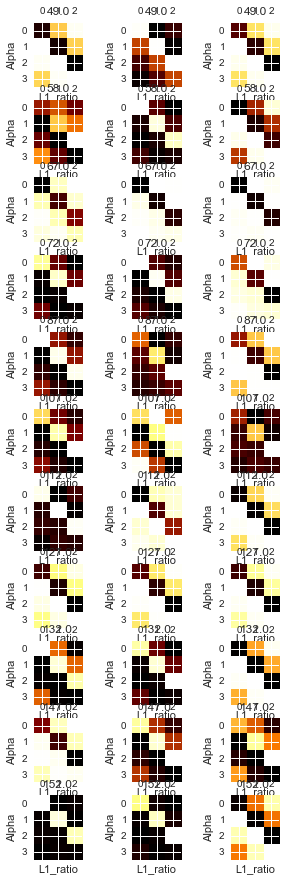

In [134]:
fig, ax = plt.subplots(11, 3, figsize=(5, 15))
for a, i, label in zip(ax.ravel(), range(n_voxels), np.unique(te).repeat(3)):
    a.matshow(LSE_3D[0,:,:,i], cmap='afmhot')#, vmax=np.max(LSEs), vmin=np.min(LSEs))
    a.set_xlabel('L1_ratio')
    a.set_ylabel('Alpha')
    a.set_title(label)

In [128]:
for i in range(LSE_3D[0,3,2].shape[0]):
    print i, ':', LSE_3D[0,2,2, i]

0 : 3.92928032714
1 : 2.80176853788
2 : 12.5410201693
3 : 1.8781993049
4 : 9.18123697438
5 : 8.63606838868
6 : 0.523516728892
7 : 2.20498603583
8 : 6.22969003697
9 : 2.46394339155
10 : 4.20041448156
11 : 3.24643346016
12 : 1.79917379506
13 : 1.36738395885
14 : 3.42290766686
15 : 0.339277002754
16 : 0.242961877921
17 : 1.20914674692
18 : 1.31741982673
19 : 2.03078370052
20 : 0.949750095532
21 : 0.257298350645
22 : 0.221683976991
23 : 0.7679859015
24 : 0.552893147869
25 : 1.00089254203
26 : 0.534717287137
27 : 0.75917310447
28 : 0.520097101598
29 : 0.7006291191
30 : 0.467326225847
31 : 0.352252748803
32 : 0.299834815943


In [133]:
for i in range(len(alphas)):
    for j in range(len(l1_ratios)):
        print alphas[j], ', ', l1_ratios[j], ':', np.mean(LSE_3D[0,i,j])

5e-06 ,  0.35 : 2.33191825643
5e-07 ,  0.4 : 2.33592696584
5e-08 ,  0.45 : 2.33925460618
5e-06 ,  0.35 : 2.33963457324
5e-07 ,  0.4 : 2.33181404468
5e-08 ,  0.45 : 2.33606044465
5e-06 ,  0.35 : 2.33937534778
5e-07 ,  0.4 : 2.33963496417
5e-08 ,  0.45 : 2.33182263122
5e-06 ,  0.35 : 2.3362046618
5e-07 ,  0.4 : 2.33939793448
5e-08 ,  0.45 : 2.33963571284


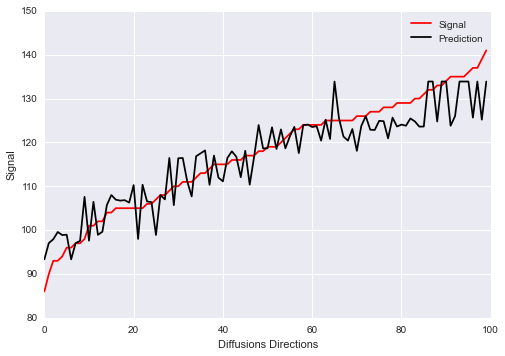

In [91]:
fig, ax = plt.subplots(1)

index = 15
a = np.argsort(data_unseen[index])
ax.plot(data_unseen[index][a], 'r', label='Signal')
ax.plot(predicts[index][a], 'black', label='Prediction')

ax.set_xlabel('Diffusion Directions')
ax.set_ylabel('Signal')
ax.legend()

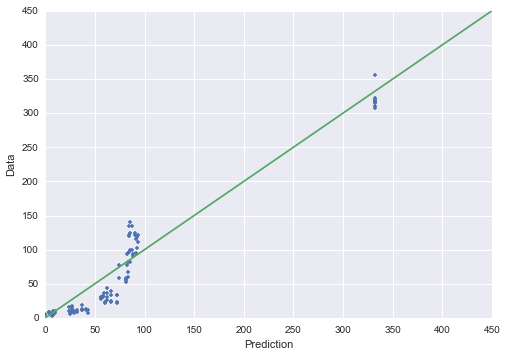

In [23]:
fig, ax = plt.subplots(1)
ax.plot(predicts[5], (data_unseen*n_variations)[5], '.')
ax.plot([0, 450], [0, 450])
ax.set_xlabel('Prediction')
ax.set_ylabel('Data')

In [23]:
#plt.plot(betas[5].reshape(-1, 45))

In [24]:
np.asarray(betas)[range(33)].shape

(33, 16290)

In [25]:
num_response = len(my_responses)
a = np.asarray(betas)[range(33)].reshape(-1, num_response)

In [28]:
b = np.zeros(num_response)
dic = {}
for i in range(num_response):
    b[i] = np.sum((a[:, i])>0)
    print '[', my_responses[i][0], my_responses[i][1], my_responses[i][2] , ']: ' , int(b[i])

[ 0.0001 0.0 0.0 ]:  36
[ 0.0003 0.0 0.0 ]:  62
[ 0.0003 0.0002 0.0002 ]:  37
[ 0.0005 0.0 0.0 ]:  8
[ 0.0005 0.0002 0.0002 ]:  74
[ 0.0005 0.0004 0.0004 ]:  78
[ 0.0007 0.0 0.0 ]:  9
[ 0.0007 0.0002 0.0002 ]:  1
[ 0.0007 0.0004 0.0004 ]:  1
[ 0.0007 0.0006 0.0006 ]:  4
[ 0.0009 0.0 0.0 ]:  45
[ 0.0009 0.0002 0.0002 ]:  47
[ 0.0009 0.0004 0.0004 ]:  2
[ 0.0009 0.0006 0.0006 ]:  34
[ 0.0009 0.0008 0.0008 ]:  34
[ 0.0011 0.0 0.0 ]:  3
[ 0.0011 0.0002 0.0002 ]:  9
[ 0.0011 0.0004 0.0004 ]:  7
[ 0.0011 0.0006 0.0006 ]:  2
[ 0.0011 0.0008 0.0008 ]:  2
[ 0.0011 0.001 0.001 ]:  0
[ 0.0013 0.0 0.0 ]:  0
[ 0.0013 0.0002 0.0002 ]:  8
[ 0.0013 0.0004 0.0004 ]:  8
[ 0.0013 0.0006 0.0006 ]:  0
[ 0.0013 0.0008 0.0008 ]:  17
[ 0.0013 0.001 0.001 ]:  38
[ 0.0013 0.0012 0.0012 ]:  47
[ 0.0015 0.0 0.0 ]:  27
[ 0.0015 0.0002 0.0002 ]:  1
[ 0.0015 0.0004 0.0004 ]:  1
[ 0.0015 0.0006 0.0006 ]:  4
[ 0.0015 0.0008 0.0008 ]:  0
[ 0.0015 0.001 0.001 ]:  0
[ 0.0015 0.0012 0.0012 ]:  53
[ 0.0015 0.0014 0.0014 ]:

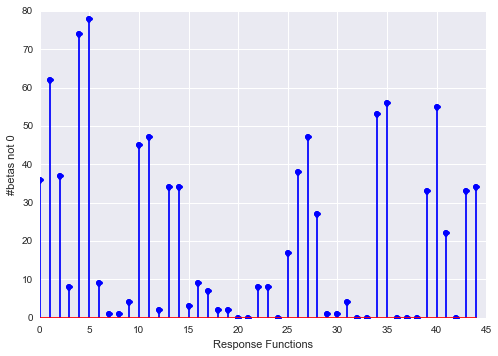

In [29]:
plt.stem(b)
plt.xlabel('Response Functions')
plt.ylabel('#betas not 0')


In [31]:
np.median(b)

8.0